In [3]:
import matplotlib.pyplot as plt
import numpy as np

C:\Users\SIVERMA\AppData\Local\Temp\ipykernel_20820\2950714547.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  Bcompress = np.fft.ifft2(Bhatcompress).astype('uint8')


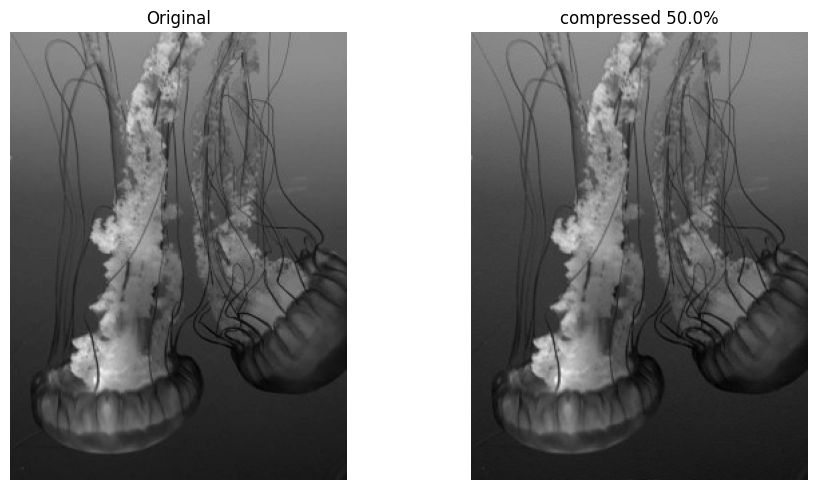

In [13]:
A = plt.imread('jelly.jpg')
B = np.mean(A, -1); 

fig, axes = plt.subplots(1, 2, figsize=(5*2, 5))
    
axes[0].imshow(B, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

Bhat = np.fft.fft2(B)

Bhatsort = np.sort(np.abs(np.reshape(Bhat,-1)))
keep = 0.5
thresh = Bhatsort[int(np.floor((1-keep)*len(Bhatsort)))]
ind = np.abs(Bhat) > thresh
Bhatcompress = Bhat * ind
Bcompress = np.fft.ifft2(Bhatcompress).astype('uint8')

axes[1].imshow(Bcompress, cmap='gray')
axes[1].set_title(f'compressed {(1-keep) *100}%')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct

## CoSaMP function (from the previous implementation)
def cosamp(Phi, u, s, tol=1e-10, max_iter=10):
    m, n = Phi.shape
    x = np.zeros(n)
    v = u
    T = np.array([], dtype=int)
    
    for _ in range(max_iter):
        y = np.abs(Phi.T @ v) # Step 1: Signal proxy
        Omega = np.argsort(y)[-2*s:] # Step 2: Identify large components
        
        T = np.union1d(T, Omega) # Merge support
        
        # Step 3: Solve least squares over the current support
        b = np.zeros(n)
        b[T] = np.linalg.lstsq(Phi[:, T], u, rcond=None)[0]
        
        # Step 4: Prune to keep only the largest s components
        T = np.argsort(np.abs(b))[-s:]
        x = np.zeros(n)
        x[T] = b[T]
        
        # Step 5: Update the residual
        v = u - Phi @ x
        
        # Step 6: Check for convergence
        if np.linalg.norm(v) < tol:
            break
    
    return x



In [25]:

## Generate signal
n = 4096  # Points in high-resolution signal
t = np.linspace(0, 1, n)
x = np.cos(2 * 97 * np.pi * t) + np.cos(2 * 777 * np.pi * t)  # Two-tone cosine signal

## Randomly sample signal
p = 128  # Number of random samples, p = n / 32
perm = np.floor(np.random.rand(p) * n).astype(int)  # Random sampling indices
y = x[perm]  # Compressed measurements

## Solve compressed sensing problem
Psi = dct(np.identity(n))  # Build Psi (DCT matrix)
Theta = Psi[perm, :]  # Measure rows of Psi (corresponding to the random samples)

# Solve via CoSaMP (Compressive Sampling Matching Pursuit)
s = cosamp(Theta, y, 10, tol=1.e-10, max_iter=10)

# Reconstruct full signal from sparse coefficients
xrecon = idct(s)

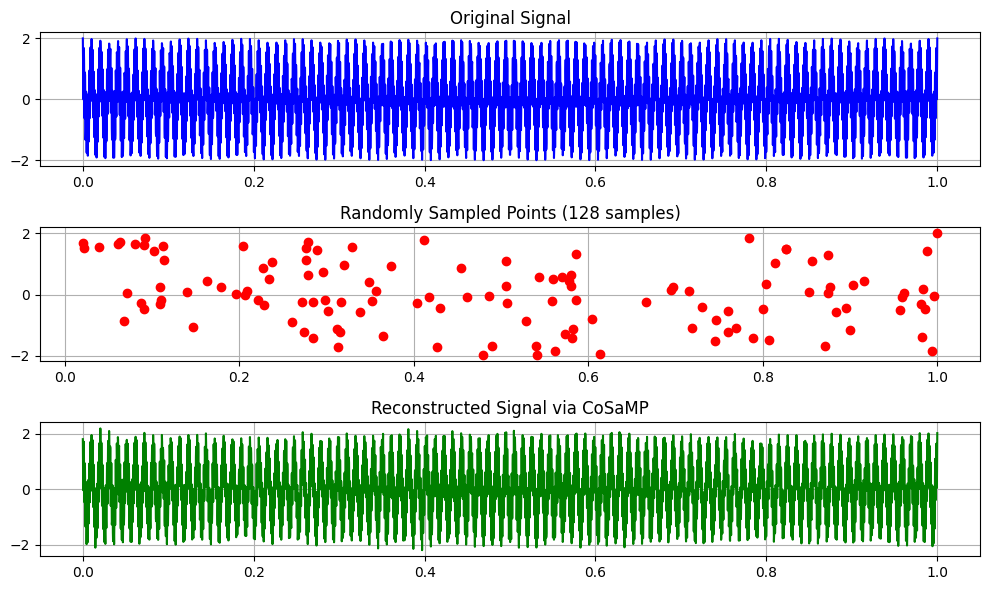

In [26]:
## Plot the original, sampled, and reconstructed signals
plt.figure(figsize=(10, 6))

# Plot the original signal
plt.subplot(3, 1, 1)
plt.plot(t, x, label="Original Signal", color='blue')
plt.title("Original Signal")
plt.grid(True)

# Plot the randomly sampled points
plt.subplot(3, 1, 2)
plt.plot(t[perm], y, 'ro', label="Sampled Points")
plt.title(f"Randomly Sampled Points ({p} samples)")
plt.grid(True)

# Plot the reconstructed signal
plt.subplot(3, 1, 3)
plt.plot(t, xrecon, label="Reconstructed Signal", color='green')
plt.title("Reconstructed Signal via CoSaMP")
plt.grid(True)

plt.tight_layout()
plt.show()

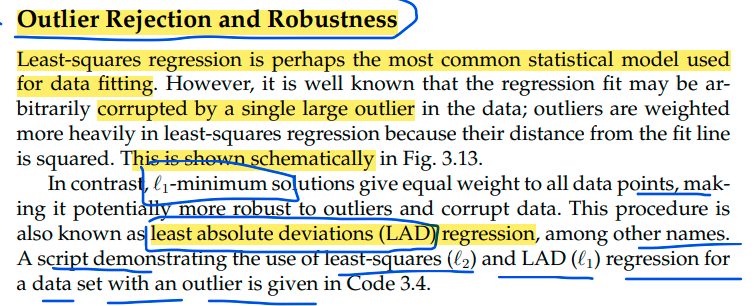

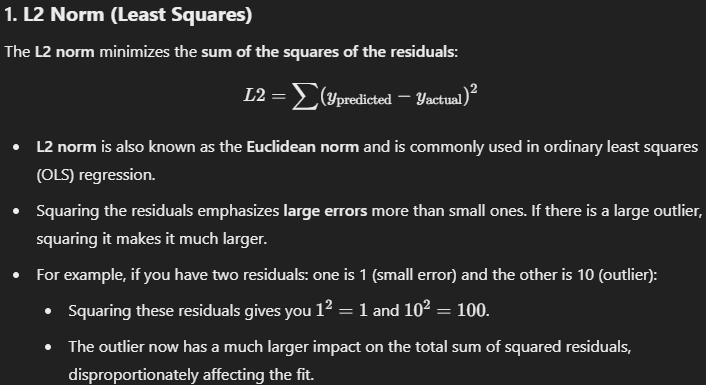

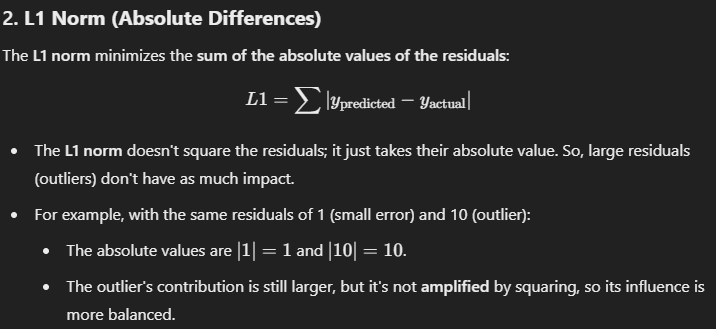

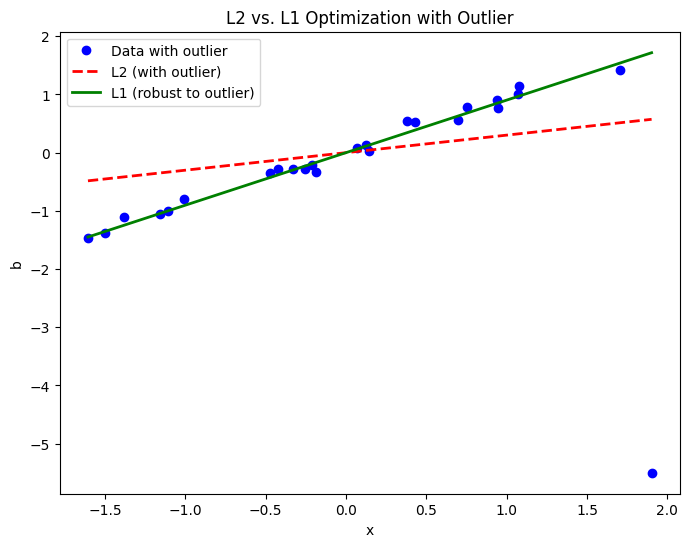

True slope (without outlier): 0.8919704684098981
Corrupted slope (L2, with outlier): 0.3013344676005403
Robust slope (L1): 0.9029757980079088


In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Generate data
x = np.sort(4 * (np.random.rand(25, 1) - 0.5), axis=0)  # Sorted random data
b = 0.9 * x + 0.1 * np.random.randn(len(x), 1)  # Noisy line: y = ax

# Least-squares solution (L2 optimization)
atrue = np.linalg.lstsq(x, b, rcond=None)[0]  # True slope using least squares

# Introduce an outlier
b[-1] = -5.5  # Modify last point to introduce an outlier

# Least-squares solution with the outlier
acorrupt = np.linalg.lstsq(x, b, rcond=None)[0]  # Slope with outlier

# Flatten acorrupt to make it 1D for minimize function
a0 = acorrupt.flatten()  # Flatten acorrupt to ensure it's one-dimensional

# Define L1 norm function for optimization
def L1_norm(a):
    return np.linalg.norm(a * x - b, ord=1)  # L1 norm

# L1 optimization to reject the outlier
res = minimize(L1_norm, a0)  # Perform L1 optimization
aL1 = res.x[0]  # Robust slope using L1 optimization

# Plotting the results
plt.figure(figsize=(8, 6))

# Original data and noisy line
plt.plot(x, b, 'bo', label="Data with outlier")  # Data points with outlier

# Plot L2 solution with outlier (least-squares)
plt.plot(x, acorrupt * x, 'r--', label="L2 (with outlier)", linewidth=2)

# Plot L1 solution (robust line)
plt.plot(x, aL1 * x, 'g-', label="L1 (robust to outlier)", linewidth=2)

# Labels and legend
plt.xlabel('x')
plt.ylabel('b')
plt.legend()
plt.title('L2 vs. L1 Optimization with Outlier')

# Show the plot
plt.show()

print(f"True slope (without outlier): {atrue[0][0]}")
print(f"Corrupted slope (L2, with outlier): {acorrupt[0][0]}")
print(f"Robust slope (L1): {aL1}")


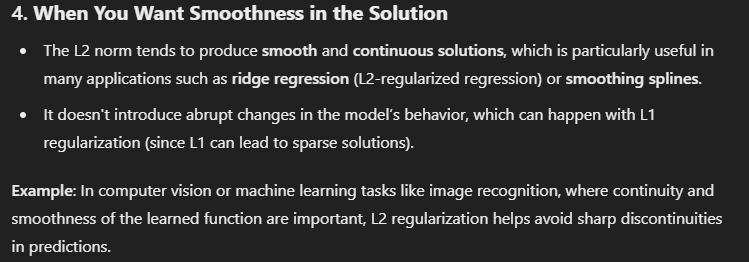

<h4>L1-norm  is good for those scenerios where the observation is less but the feature are in good amount, how this helps <br>
suppose in medical care the feature for heart-attack can be multiple like diet , geography, genetic so because l1 norm pushes the <br>
sparsity so it will try to make each small detials caught by data point as different as possible meaning more helpful </h4>

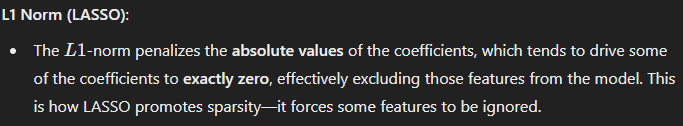

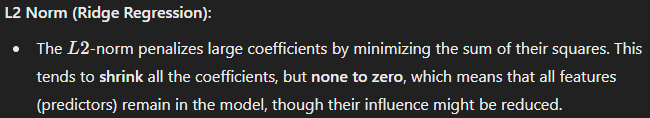

# RCPA
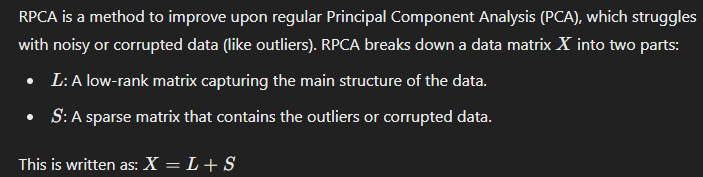

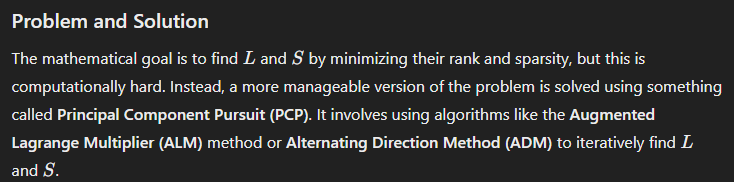

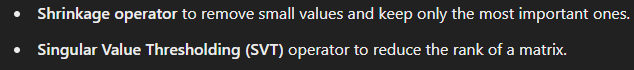

In [79]:
import numpy as np

# Shrinkage operator
def shrink(X, tau):
    Y = np.abs(X) - tau
    return np.sign(X) * np.maximum(Y, np.zeros_like(Y))

# Singular Value Thresholding (SVT) operator
def SVT(X, tau):
    U, S, VT = np.linalg.svd(X, full_matrices=False)
    return U @ np.diag(shrink(S, tau)) @ VT

# RPCA using Alternating Directions Method (ADM)
def RPCA(X, max_iter=1000, tol=1e-7):
    n1, n2 = X.shape
    mu = n1 * n2 / (4 * np.sum(np.abs(X)))
    lambd = 1 / np.sqrt(max(n1, n2))
    thresh = tol * np.linalg.norm(X)
    
    # Initialize variables
    L = np.zeros_like(X)
    S = np.zeros_like(X)
    Y = np.zeros_like(X)
    count = 0

    # Iterative process
    while (np.linalg.norm(X - L - S) > thresh) and (count < max_iter):
        L = SVT(X - S + (1 / mu) * Y, 1 / mu)
        S = shrink(X - L + (1 / mu) * Y, lambd / mu)
        Y = Y + mu * (X - L - S)
        count += 1
    
    return L, S



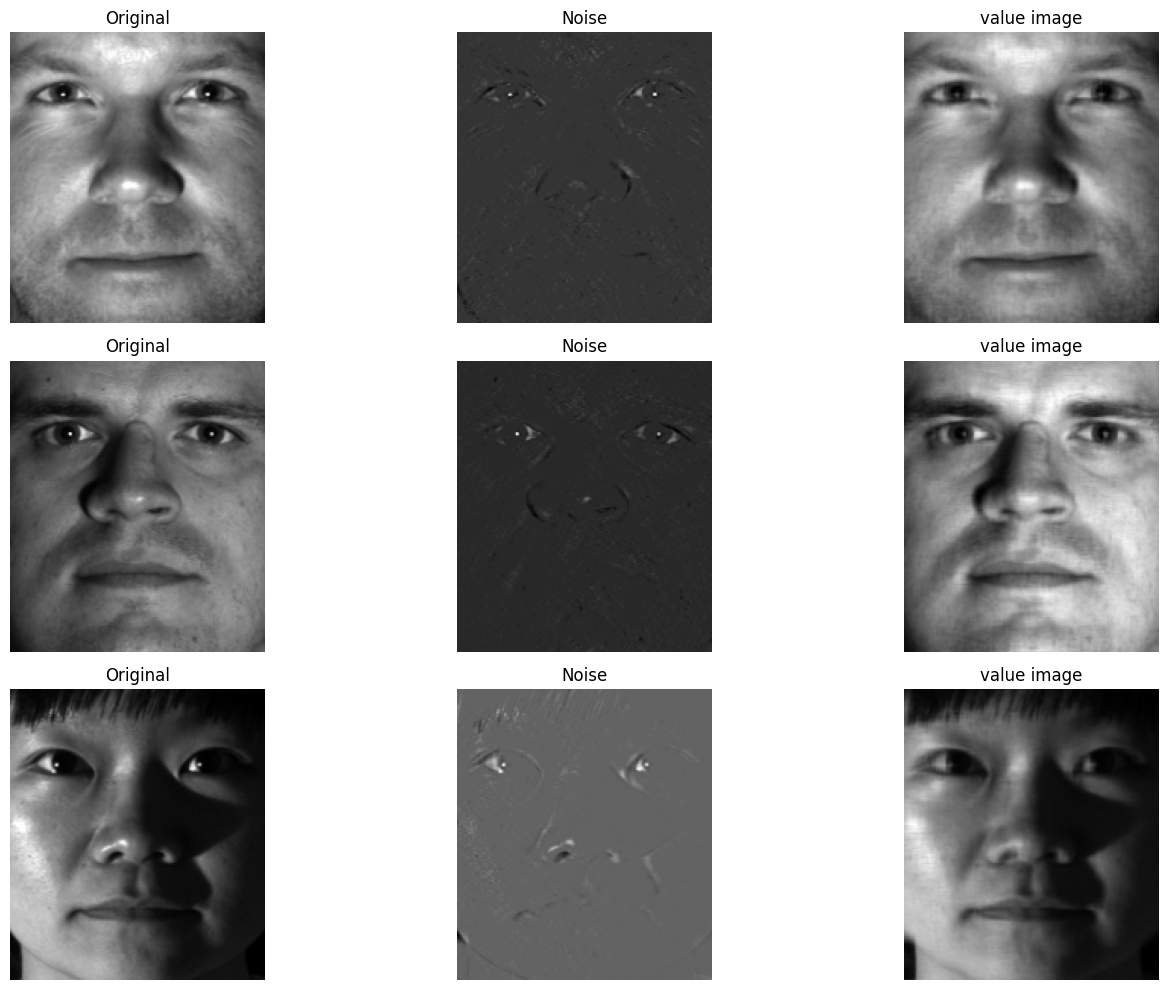

In [83]:
fig, axes = plt.subplots(3, 3, figsize=(5*3, 10))

for i,img in enumerate(['archive\CroppedYalePNG\yaleB03_P00A+010E-20.png','archive\CroppedYalePNG\yaleB04_P00A-020E-10.png','archive\CroppedYalePNG\yaleB05_P00A+060E-20.png']):
    X = plt.imread(img)
    L, S = RPCA(X)
    axes[i,0].imshow(X, cmap='gray')
    axes[i,0].set_title('Original')
    axes[i,0].axis('off')

    axes[i,1].imshow(S, cmap='gray')
    axes[i,1].set_title('Noise')
    axes[i,1].axis('off')

    axes[i,2].imshow(L, cmap='gray')
    axes[i,2].set_title('value image')
    axes[i,2].axis('off')

plt.tight_layout()
plt.show()


# EXERCISE 

Exercise 3-1. Load the image dog.jpg and convert to grayscale. We will repeat
Exercise 2-1, using the FFT to compress the image at different compression ratios. However, now, we will compare the error versus compression ratio for
the image downsampled at different resolutions. Compare the original image
(2000×1500) and downsampled copies of the following resolutions: 1000×750,
500 × 375, 200 × 150, and 100 × 75. Plot the error versus compression ratio for
each image resolution on the same plot. Explain the observed trends.

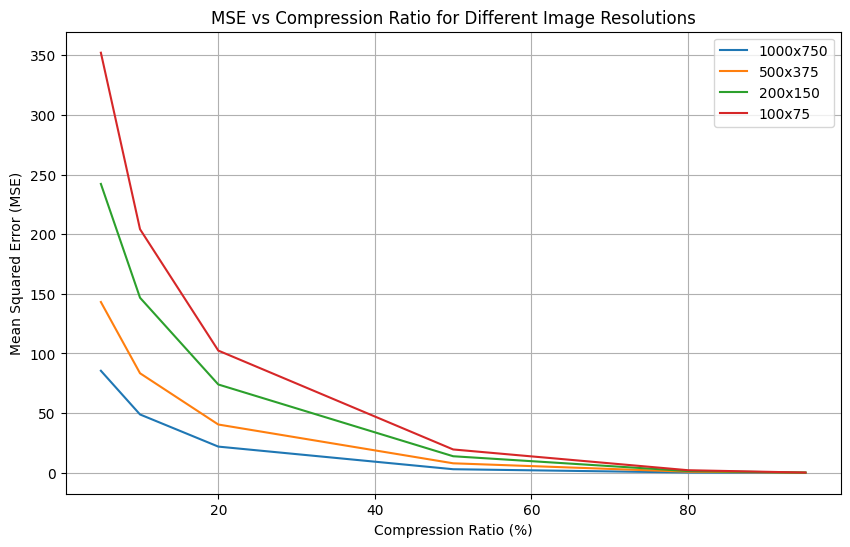

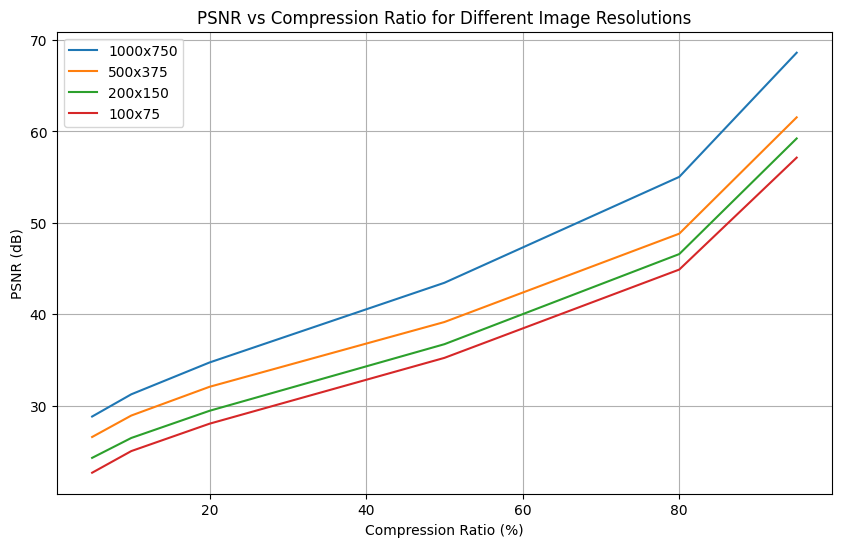

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.fftpack import fft2, ifft2

# 1. Load and convert the image to grayscale
image = Image.open('lion.jpg').convert('L')
original_image = np.array(image)

# 2. Define downsampled resolutions
resolutions = [(1000, 750), (500, 375), (200, 150), (100, 75)]
downsampled_images = [np.array(image.resize(res)) for res in resolutions]

# 3. FFT Compression function
def compress_fft(image, compression_ratio):
    # FFT transform
    fft_image = fft2(image)
    # Get magnitude of the FFT
    fft_mag = np.abs(fft_image)
    # Get threshold to keep only the largest values
    threshold = np.percentile(fft_mag, 100 - compression_ratio)
    # Apply threshold
    fft_image[fft_mag < threshold] = 0
    # Inverse FFT to reconstruct image
    compressed_image = np.abs(ifft2(fft_image))
    return compressed_image

# 4. Manual MSE Calculation
def calculate_mse(original, compressed):
    return np.mean((original - compressed) ** 2)

# 5. PSNR Calculation (Peak Signal-to-Noise Ratio)
def calculate_psnr(original, compressed):
    mse = calculate_mse(original, compressed)
    if mse == 0:  # perfect match case
        return float('inf')
    max_pixel_value = 255.0  # Assuming 8-bit grayscale image
    psnr = 20 * np.log10(max_pixel_value / np.sqrt(mse))
    return psnr

# 6. Compression ratios to test
compression_ratios = [5, 10, 20, 50, 80, 95]  # in percentages
errors_mse = {res: [] for res in resolutions}
errors_psnr = {res: [] for res in resolutions}

# 7. Perform FFT compression and calculate errors
for img, res in zip(downsampled_images, resolutions):
    for ratio in compression_ratios:
        compressed_img = compress_fft(img, ratio)
        mse_error = calculate_mse(img, compressed_img)
        psnr_error = calculate_psnr(img, compressed_img)
        errors_mse[res].append(mse_error)
        errors_psnr[res].append(psnr_error)

# 8. Plot error (MSE) vs compression ratio for each resolution
plt.figure(figsize=(10, 6))
for res in resolutions:
    plt.plot(compression_ratios, errors_mse[res], label=f'{res[0]}x{res[1]}')

plt.xlabel('Compression Ratio (%)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs Compression Ratio for Different Image Resolutions')
plt.legend()
plt.grid(True)
plt.show()

# 9. Plot PSNR vs compression ratio for each resolution
plt.figure(figsize=(10, 6))
for res in resolutions:
    plt.plot(compression_ratios, errors_psnr[res], label=f'{res[0]}x{res[1]}')

plt.xlabel('Compression Ratio (%)')
plt.ylabel('PSNR (dB)')
plt.title('PSNR vs Compression Ratio for Different Image Resolutions')
plt.legend()
plt.grid(True)
plt.show()


Exercise 3-2. This example will explore geometry and sampling probabilities in
high-dimensional spaces. Consider a two-dimensional square dart board with
length L = 2 on both sides and a circle of radius R = 1 in the middle. Write a
program to throw 10 000 darts by generating a uniform random x and y position
on the square. Compute the radius for each point and compute what fraction
land inside the circle (i.e., how many have radius < 1). Is this consistent with
your expectation based on the area of the circle and the square?
Repeat this experiment, throwing 10 000 darts randomly (sampled from a uniform distribution) on an N-dimensional cube (length L = 2) with an N-dimensional
sphere inside (radius R = 1), for N = 2 through N = 10. For a given N, what
fraction of the points land inside the sphere. Plot this fraction versus N. Also
compute the histogram of the radii of the randomly sampled points for each N
and plot these. What trends do you notice in the data?

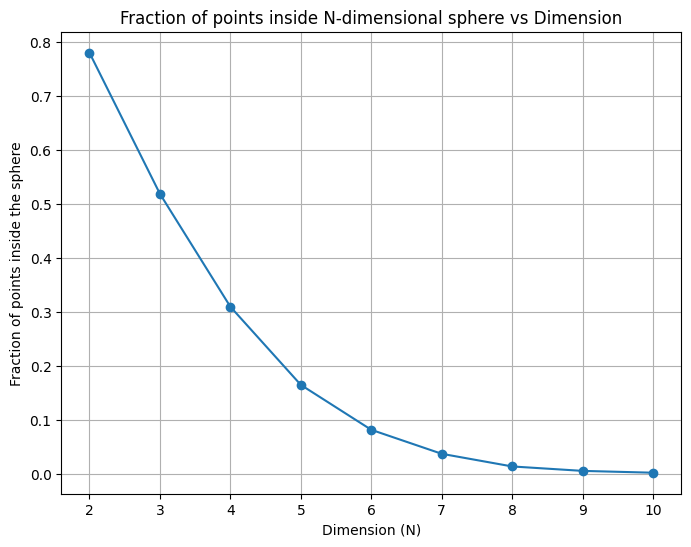

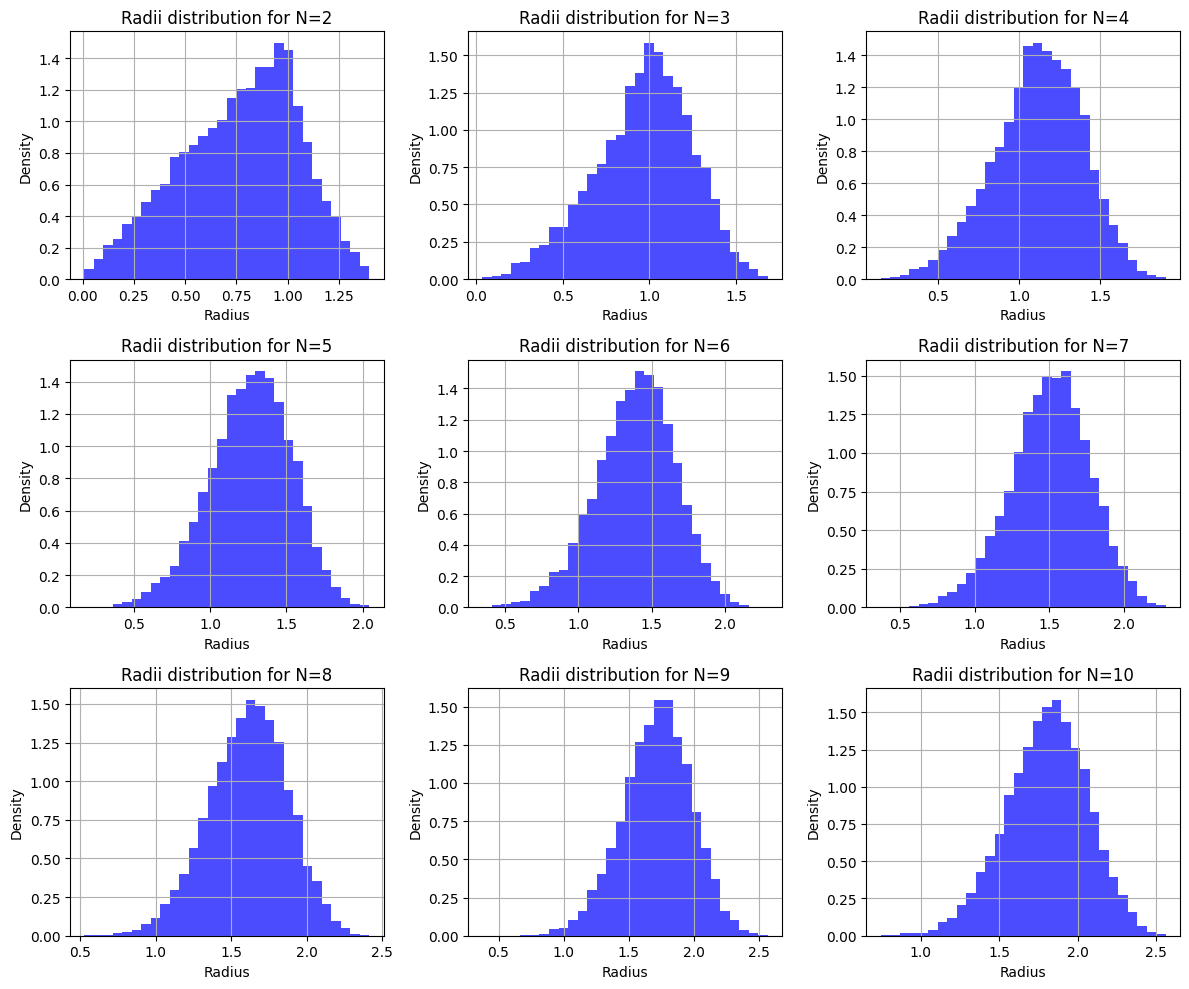

In [86]:
import numpy as np
import matplotlib.pyplot as plt

# Function to simulate darts in N-dimensional space
def simulate_darts(N, num_darts=10000):
    # Generate num_darts points, each with N random coordinates between -1 and 1
    points = np.random.uniform(-1, 1, size=(num_darts, N))
    
    # Calculate the distance (radius) of each point from the origin
    radii = np.linalg.norm(points, axis=1)
    
    # Count how many points fall inside the N-dimensional sphere (radius <= 1)
    inside_sphere = np.sum(radii <= 1)
    
    # Return the fraction of points inside the sphere and the radii
    fraction_inside = inside_sphere / num_darts
    return fraction_inside, radii

# Dimensions to simulate (N = 2 to 10)
dimensions = range(2, 11)
num_darts = 10000

# Store the fractions and radii histograms
fractions = []
radii_histograms = []

# Simulate for each dimension N
for N in dimensions:
    fraction_inside, radii = simulate_darts(N, num_darts)
    fractions.append(fraction_inside)
    radii_histograms.append(radii)

# Plot the fraction of points inside the sphere vs dimension
plt.figure(figsize=(8, 6))
plt.plot(dimensions, fractions, marker='o')
plt.xlabel('Dimension (N)')
plt.ylabel('Fraction of points inside the sphere')
plt.title('Fraction of points inside N-dimensional sphere vs Dimension')
plt.grid(True)
plt.show()

# Plot histograms of the radii for each dimension
plt.figure(figsize=(12, 10))
for i, N in enumerate(dimensions):
    plt.subplot(3, 3, i + 1)
    plt.hist(radii_histograms[i], bins=30, density=True, alpha=0.7, color='b')
    plt.title(f'Radii distribution for N={N}')
    plt.xlabel('Radius')
    plt.ylabel('Density')
    plt.grid(True)

plt.tight_layout()
plt.show()


Exercise 3-3. This exercise will explore the relationship between the sparsity K,
the signal size n, and the number of samples p in compressed sensing.
(a) For n = 1000 and K = 5, create a K-sparse vector s of Fourier coefficients
in a Fourier basis Ψ. For each p from 1 to 100, create a Gaussian random
sampling matrix C ∈ R
p×n
to create a measurement vector y = CΨs. Use
compressed sensing based on this measurement to estimate ˆs. For each
p, repeat this with at least 10 realizations of the random measurement
matrix C. Plot the average relative error of kˆs − sk2/ksk versus p; it may
be helpful to visualize the errors with a box-and-whisker plot. Explain the
trends. Also plot the average `1 and `0 error versus p.
(b) Repeat the above experiment for K = 1 through K = 20. What changes?
(c) Now repeat the above experiment for K = 5, varying the signal size using
n = 100, n = 500, n = 1000, n = 2000, and n = 5000

c:\Users\SIVERMA\Documents\Experimenting\________DEEPLEARNING\CLASSIFICATION___CIFAR\DLENV\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\SIVERMA\Documents\Experimenting\________DEEPLEARNING\CLASSIFICATION___CIFAR\DLENV\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\SIVERMA\Documents\Experimenting\________DEEPLEARNING\CLASSIFICATION___CIFAR\DLENV\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: Conver

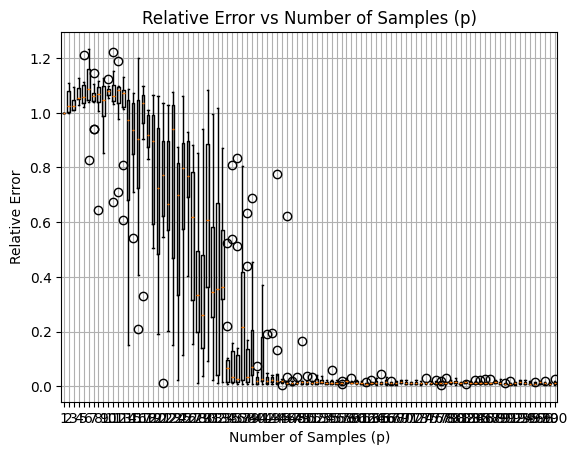

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from scipy.fftpack import dct  # Discrete Cosine Transform for Fourier basis

# Function to create a K-sparse vector of Fourier coefficients
def create_sparse_signal(n, K):
    s = np.zeros(n)
    non_zero_indices = np.random.choice(n, K, replace=False)
    s[non_zero_indices] = np.random.randn(K)
    return s

# Function to create a Gaussian random sampling matrix
def create_sampling_matrix(p, n):
    return np.random.randn(p, n)

# Function to perform compressed sensing and return estimated signal
def compressed_sensing(C, y, alpha=0.01):
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(C, y)
    return lasso.coef_

# Parameters
n = 1000
K = 5
ps = np.arange(1, 101)
num_realizations = 10

# Arrays to store errors
relative_errors = np.zeros((num_realizations, len(ps)))

# Run experiment
for i, p in enumerate(ps):
    for j in range(num_realizations):
        # Create K-sparse signal
        s = create_sparse_signal(n, K)
        
        # Fourier basis (using Discrete Cosine Transform as an approximation)
        Psi = dct(np.eye(n), norm='ortho')
        
        # Measurement vector y = C * Psi * s
        C = create_sampling_matrix(p, n)
        y = C @ Psi @ s
        
        # Reconstruct signal using compressed sensing
        s_hat = compressed_sensing(C @ Psi, y)
        
        # Calculate relative error
        relative_errors[j, i] = np.linalg.norm(s_hat - s) / np.linalg.norm(s)

# Plot relative errors using box-and-whisker plot
plt.boxplot(relative_errors, positions=ps)
plt.xlabel('Number of Samples (p)')
plt.ylabel('Relative Error')
plt.title('Relative Error vs Number of Samples (p)')
plt.grid(True)
plt.show()


Exercise 3-5. Generate a DFT matrix Ψ for n = 512. We will use this as a basis
for compressed sensing, and we will compute the incoherence of this basis and
different measurement matrices. For p = 16, create different random measurement matrices C given by Gaussian random measurements, Bernoulli random
measurements, and random single-pixel measurements. For each matrix, normalize the length of each row to 1. Now, for each measurement matrix type,
compute the incoherence µ(C, Ψ). Repeat this for many random instances of
each C matrix type and compare the histogram of incoherence values for each
matrix type. Further, compare the histogram of each inner product √
nhck, ψj
i
for each matrix type. Discuss any trends and the implications for compressed
sensing with these measurement matrices. Are there other factors that are relevant for the sensing matrix

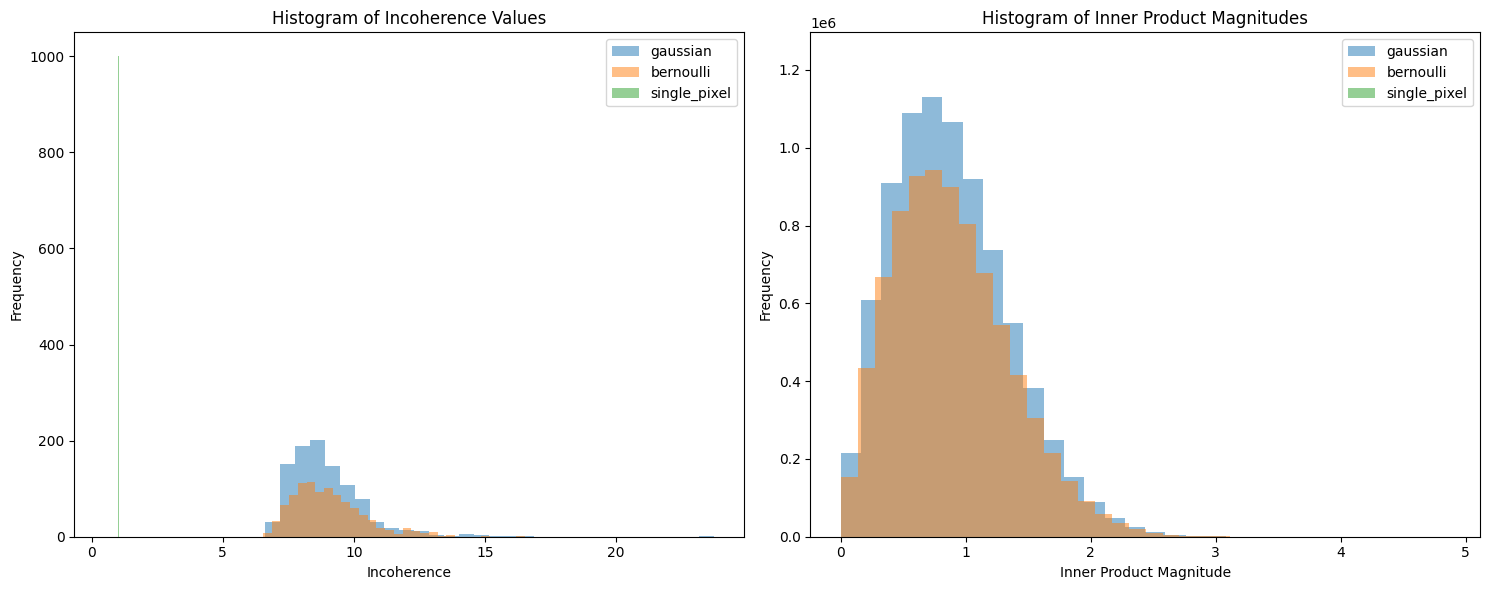

Incoherence Statistics:
Gaussian:
  Mean: 8.9513
  Median: 8.6969
  Min: 6.6036
  Max: 23.7339

Bernoulli:
  Mean: 9.0285
  Median: 8.8210
  Min: 6.5298
  Max: 16.5312

Single_pixel:
  Mean: 1.0000
  Median: 1.0000
  Min: 1.0000
  Max: 1.0000

Inner Product Statistics:
Gaussian:
  Mean: 0.8863
  Median: 0.8331
  Min: 0.0001
  Max: 4.8717

Bernoulli:
  Mean: 0.8861
  Median: 0.8331
  Min: 0.0000
  Max: 4.0659

Single_pixel:
  Mean: 1.0000
  Median: 1.0000
  Min: 1.0000
  Max: 1.0000



In [100]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft

def generate_dft_matrix(n):
    i, j = np.meshgrid(np.arange(n), np.arange(n))
    omega = np.exp(-2 * np.pi * 1j / n)
    return np.power(omega, i * j) / np.sqrt(n)

def generate_measurement_matrix(n, p, matrix_type):
    if matrix_type == 'gaussian':
        C = np.random.randn(p, n)
    elif matrix_type == 'bernoulli':
        C = np.random.choice([-1, 1], size=(p, n))
    elif matrix_type == 'single_pixel':
        C = np.zeros((p, n))
        random_indices = np.random.choice(n, p, replace=False)
        C[np.arange(p), random_indices] = 1
    else:
        raise ValueError("Invalid matrix type")
    
    # Normalize each row
    return C / np.linalg.norm(C, axis=1)[:, np.newaxis]

def compute_incoherence(C, Psi):
    n = Psi.shape[0]
    return n * np.max(np.abs(C @ Psi) ** 2)

def compute_inner_products(C, Psi):
    n = Psi.shape[0]
    return np.sqrt(n) * np.abs(C @ Psi)

# Set parameters
n = 512
p = 16
num_iterations = 1000
matrix_types = ['gaussian', 'bernoulli', 'single_pixel']

# Generate DFT matrix
Psi = generate_dft_matrix(n)

# Initialize dictionaries to store results
incoherence_results = {mt: [] for mt in matrix_types}
inner_products_results = {mt: [] for mt in matrix_types}

# Perform iterations
for _ in range(num_iterations):
    for matrix_type in matrix_types:
        C = generate_measurement_matrix(n, p, matrix_type)
        incoherence_results[matrix_type].append(compute_incoherence(C, Psi))
        inner_products_results[matrix_type].extend(compute_inner_products(C, Psi).flatten())

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot incoherence histograms
for matrix_type in matrix_types:
    ax1.hist(incoherence_results[matrix_type], bins=30, alpha=0.5, label=matrix_type)
ax1.set_xlabel('Incoherence')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of Incoherence Values')
ax1.legend()

# Plot inner product histograms
for matrix_type in matrix_types:
    ax2.hist(inner_products_results[matrix_type], bins=30, alpha=0.5, label=matrix_type)
ax2.set_xlabel('Inner Product Magnitude')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of Inner Product Magnitudes')
ax2.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("Incoherence Statistics:")
for matrix_type in matrix_types:
    incoherence_values = incoherence_results[matrix_type]
    print(f"{matrix_type.capitalize()}:")
    print(f"  Mean: {np.mean(incoherence_values):.4f}")
    print(f"  Median: {np.median(incoherence_values):.4f}")
    print(f"  Min: {np.min(incoherence_values):.4f}")
    print(f"  Max: {np.max(incoherence_values):.4f}")
    print()

print("Inner Product Statistics:")
for matrix_type in matrix_types:
    inner_product_values = inner_products_results[matrix_type]
    print(f"{matrix_type.capitalize()}:")
    print(f"  Mean: {np.mean(inner_product_values):.4f}")
    print(f"  Median: {np.median(inner_product_values):.4f}")
    print(f"  Min: {np.min(inner_product_values):.4f}")
    print(f"  Max: {np.max(inner_product_values):.4f}")
    print()